# Card Scoring Algorithm Research
## MTGEcoRec Commander Recommendation System

**Purpose:** Research and compare 7 different card scoring algorithms  
**Status:** Phase 1 - Research Only (No Production Integration)  
**Date:** January 15, 2026  

This notebook implements and evaluates multiple card scoring strategies to identify the best approach for recommending cards to Commander players.

## Section 1: Setup & Database Connection

In [2]:
import os
from dotenv import load_dotenv
from pymongo import MongoClient
import pandas as pd
import numpy as np
import requests
from collections import defaultdict
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load environment
load_dotenv('/workspaces/mtgecorec/.env')

# CosmosDB connection
COSMOS_CONNECTION_STRING = os.getenv('COSMOS_CONNECTION_STRING')
if not COSMOS_CONNECTION_STRING:
    print("⚠️ COSMOS_CONNECTION_STRING not found in .env")
    print("Attempting to use local development setup...")
else:
    try:
        client = MongoClient(COSMOS_CONNECTION_STRING, serverSelectionTimeoutMS=5000)
        db = client['mtgecorec']
        cards_collection = db['cards']
        # Test connection
        db.command('ping')
        print("✅ Connected to CosmosDB")
    except Exception as e:
        print(f"⚠️ CosmosDB connection failed: {e}")
        print("Continuing with error handling...")

print(f"Python version: {pd.__version__}")

✅ Connected to CosmosDB
Python version: 2.3.3


## Section 2: Load Commander-Legal Cards

In [25]:
# Query Commander-legal cards
try:
    query = {
        'legalities.commander': 'legal',
        'type_line': {'$not': {'$regex': 'token'}}
    }

    projection = {
        'name': 1, 'oracle_text': 1, 'type_line': 1, 
        'mana_cost': 1, 'cmc': 1, 'colors': 1, 'color_identity': 1,
        'rarity': 1, 'edhrec_rank': 1, 'legalities': 1, '_id': 0
    }

    cards_cursor = cards_collection.find(query, projection)
    cards_data = list(cards_cursor)
    print(f"✅ Loaded {len(cards_data)} Commander-legal cards from CosmosDB")
    
except Exception as e:
    print(f"⚠️ Error loading cards: {e}")
    cards_data = []

# Display statistics
if cards_data:
    print(f"\n📊 Card Statistics:")
    print(f"   Total cards: {len(cards_data):,}")
    
    # Sample card
    sample = cards_data[0]
    print(f"\n📋 Sample Card:")
    print(f"   Name: {sample.get('name')}")
    print(f"   Type: {sample.get('type_line')}")
    print(f"   CMC: {sample.get('cmc')}")
    print(f"   Rarity: {sample.get('rarity')}")
    print(f"   EDHREC Rank: {sample.get('edhrec_rank', 'Not available')}")

✅ Loaded 99854 Commander-legal cards from CosmosDB

📊 Card Statistics:
   Total cards: 99,854

📋 Sample Card:
   Name: Forest
   Type: Basic Land — Forest
   CMC: 0.0
   Rarity: common
   EDHREC Rank: Not available


In [30]:
cards_collection.find_one({'name': 'Alela, Artful Provocateur'})

{'_id': ObjectId('68d04f6759fb4c414fdaf0bb'),
 'object': 'card',
 'id': '31c99a7d-a70b-4599-9bd2-be7a5cac28ff',
 'oracle_id': '936ae5dc-9838-47f3-ba1f-66523a7f5b76',
 'multiverse_ids': [],
 'tcgplayer_id': 582800,
 'name': 'Alela, Artful Provocateur',
 'lang': 'en',
 'released_at': '2024-08-02',
 'uri': 'https://api.scryfall.com/cards/31c99a7d-a70b-4599-9bd2-be7a5cac28ff',
 'scryfall_uri': 'https://scryfall.com/card/plst/ELD-324/alela-artful-provocateur?utm_source=api',
 'layout': 'normal',
 'highres_image': True,
 'image_status': 'highres_scan',
 'image_uris': {'small': 'https://cards.scryfall.io/small/front/3/1/31c99a7d-a70b-4599-9bd2-be7a5cac28ff.jpg?1723436064',
  'normal': 'https://cards.scryfall.io/normal/front/3/1/31c99a7d-a70b-4599-9bd2-be7a5cac28ff.jpg?1723436064',
  'large': 'https://cards.scryfall.io/large/front/3/1/31c99a7d-a70b-4599-9bd2-be7a5cac28ff.jpg?1723436064',
  'png': 'https://cards.scryfall.io/png/front/3/1/31c99a7d-a70b-4599-9bd2-be7a5cac28ff.png?1723436064',
  '

In [22]:
# all distinct full type_line values
types = cards_collection.distinct("type_line")

types_no_tokens = [t for t in types if "token" not in t.lower()]

# unique left-side parts
unique_left_types = sorted({t.split("—")[0].strip() for t in types_no_tokens})

print(unique_left_types)

['Artifact', 'Artifact // Artifact', 'Artifact // Artifact Creature', 'Artifact // Creature', 'Artifact // Land', 'Artifact // Sorcery', 'Artifact Creature', 'Artifact Enchantment', 'Artifact Land', 'Basic Creature', 'Basic Land', 'Basic Snow Land', 'Battle', 'Boss', 'Card', 'Card // Card', 'Conspiracy', 'Creature', 'Dungeon', 'Eaturecray', 'Elemental Instant', 'Elite Creature', 'Emblem', 'Emblem // Card', 'Enchantment', 'Enchantment // Artifact', 'Enchantment // Creature', 'Enchantment // Enchantment', 'Enchantment // Instant', 'Enchantment // Land', 'Enchantment // Legendary Artifact', 'Enchantment // Legendary Creature', 'Enchantment // Legendary Planeswalker', 'Enchantment // Sorcery', 'Enchantment Creature', 'Enchantment Land', 'Hero', 'Hero Artifact', 'Host Artifact Creature', 'Host Creature', 'Instant', 'Instant // Instant', 'Instant // Land', 'Instant // Sorcery', 'Instant // Sorcery // Sorcery', 'Instant Creature', 'Kindred Artifact', 'Kindred Enchantment', 'Kindred Instant', 

In [44]:
import requests
import pandas as pd

# The variants endpoint is for general searching
url = "https://backend.commanderspellbook.com/variants/"

# "q" is the search query. Leave empty to get everything, 
# or use "ci:b" for Mono-Black, "legal:commander" for legality, etc.
params = {
    "q": "legal:commander",
    "ordering": "popularity" # Or 'price', 'identity', etc.
}

print("Fetching all Commander-legal combos...")
response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    # 'results' in this endpoint is a simple list of combo objects
    combo_list = data.get('results', [])
    
    all_rows = []
    for combo in combo_list:
        # Extract basic info
        identity = combo.get('identity', 'N/A')
        description = combo.get('description', 'N/A').replace('\n', ' ')
        
        # Get card names from the 'uses' list
        card_names = [u['card']['name'] for u in combo.get('uses', [])]
        
        all_rows.append({
            "Cards": ", ".join(card_names),
            "Colors": identity,
            "Description": description[:70] + "...",
            "Price (USD)": combo.get('prices', {}).get('tcgplayer', 'N/A')
        })

    df = pd.DataFrame(all_rows)
    # print(df.to_string(index=False, justify='left'))
    
    # print(f"\nShowing {len(all_rows)} of {data.get('count')} total combos.")
    # print(f"Next page: {data.get('next')}")

else:
    print(f"Error: {response.status_code}")

df

Fetching all Commander-legal combos...


,Cards,Colors,Description,Price (USD)
0,"Cryptolith Rite, Ant Queen, Maelstrom Wanderer...",RGWU,"Activate Ant Queen by paying {1}{G}, creating ...",38.08
1,"Seedcradle Witch, Bloom Tender, Prismwake Merrow",GWU,Cast Prismwake Merrow by paying {2}{U}. Prismw...,10.41
2,"Carrion Feeder, Naru Meha, Master Wizard, Pris...",UB,Cast Prison Break either from your hand by pay...,4.16
3,"Technomancer, Bloodflow Connoisseur, Phyrexian...",UB,Cast Technomancer by paying {5}{B}{B}. When Te...,3.13
4,"Lonis, Genetics Expert, Clock of Omens, Power ...",GWU,Activate Power Conduit by tapping it and remov...,16.65
...,...,...,...,...
95,"Godo, Bandit Warlord, Displacer Kitten, Spellb...",UR,Declare Godo and the creature with Spellbinder...,27.55
96,"Jegantha, the Wellspring, Horde of Notions, Bl...",WUBRG,"Activate Jegantha by tapping it, adding {W}{U}...",10.96
97,"Emry, Lurker of the Loch, Thornbite Staff, Sar...",UBR,"Activate Emry by tapping it, allowing you to c...",19.46
98,"Puppet Conjurer, Dross Scorpion, Krark-Clan Ir...",UB,Activate Puppet's Conjurer by paying {1} and t...,50.35


## Section 3: Fetch External Data (Commander Spellbook)

In [ ]:
def fetch_combo_cards():
    """Fetch all cards that appear in infinite combos from Commander Spellbook API"""
    combo_cards = set()
    
    url = "https://backend.commanderspellbook.com/api/variants/"
    page = 1
    
    try:
        while url and page <= 50:  # Safety limit
            try:
                print(f"Fetching page {page}...")
                response = requests.get(url, params={'limit': 100, 'offset': (page-1)*100}, timeout=10)
                response.raise_for_status()
                data = response.json()
                
                # Extract card names from variants
                for variant in data.get('results', []):
                    for card_usage in variant.get('uses', []):
                        card_name = card_usage.get('card', {}).get('name')
                        if card_name:
                            combo_cards.add(card_name)
                
                # Check for next page
                url = data.get('next')
                page += 1
                    
            except Exception as e:
                print(f"Error fetching page {page}: {e}")
                break
        
        print(f"✅ Found {len(combo_cards)} cards in infinite combos")
        return combo_cards
        
    except Exception as e:
        print(f"⚠️ Commander Spellbook API failed: {e}")
        print("Continuing without combo data...")
        return set()

# Fetch combo cards
combo_cards = fetch_combo_cards()
print(f"Total combo cards identified: {len(combo_cards)}")

Fetching page 1...
Error fetching page 1: 404 Client Error: Not Found for url: https://commanderspellbook.com/api/variants/?limit=100&offset=0
✅ Found 0 cards in infinite combos
Total combo cards identified: 0


## Section 4: Archetype Detection System

In [4]:
def detect_archetypes(card_data):
    """Detect all applicable archetypes for a card based on oracle text and type line"""
    oracle_text = card_data.get('oracle_text', '').lower()
    type_line = card_data.get('type_line', '').lower()
    cmc = card_data.get('cmc', 0)
    
    flags = {}
    
    # Ramp detection
    ramp_keywords = ['add {', 'search your library for a land', 'search your library for up to', 
                     'lands you control have', 'whenever a land enters']
    flags['is_ramp'] = any(kw in oracle_text for kw in ramp_keywords) or 'land' in type_line
    
    # Removal detection
    removal_keywords = ['destroy target', 'exile target', 'counter target spell', 
                       'return target', 'sacrifice target']
    flags['is_removal'] = any(kw in oracle_text for kw in removal_keywords)
    
    # Board wipe detection
    wipe_keywords = ['destroy all', 'exile all creatures', 'each player sacrifices']
    flags['is_board_wipe'] = any(kw in oracle_text for kw in wipe_keywords)
    
    # Card draw detection
    draw_keywords = ['draw cards', 'draw a card', 'draw two cards', 
                    'whenever you draw', 'draw that many']
    flags['is_card_draw'] = any(kw in oracle_text for kw in draw_keywords)
    
    # Tutor detection
    tutor_keywords = ['search your library for a card', 'search your library for up to',
                     'search your library for a creature', 'search your library for an']
    flags['is_tutor'] = any(kw in oracle_text for kw in tutor_keywords) and 'land' not in oracle_text
    
    # Protection detection
    protection_keywords = ['hexproof', 'indestructible', 'protection from', 'ward', 'shroud']
    flags['is_protection'] = any(kw in oracle_text for kw in protection_keywords)
    
    # Finisher detection (high CMC or win condition)
    finisher_keywords = ['win the game', 'each opponent loses', 'deal damage to each opponent']
    flags['is_finisher'] = cmc >= 6 or any(kw in oracle_text for kw in finisher_keywords)
    
    # Utility detection
    utility_keywords = ['choose one', 'choose two', 'modal']
    flags['is_utility'] = any(kw in oracle_text for kw in utility_keywords)
    
    # Aristocrats detection
    aristocrats_keywords = ['whenever a creature dies', 'whenever you sacrifice', 
                           'sacrifice a creature']
    flags['is_aristocrats'] = any(kw in oracle_text for kw in aristocrats_keywords)
    
    # Token detection
    token_keywords = ['create a', 'creature token', 'token copy']
    flags['is_tokens'] = any(kw in oracle_text for kw in token_keywords)
    
    # Counter detection
    counter_keywords = ['+1/+1 counter', 'proliferate', 'put a counter on']
    flags['is_counters'] = any(kw in oracle_text for kw in counter_keywords)
    
    # Graveyard detection
    graveyard_keywords = ['from your graveyard', 'return target card from', 
                         'from a graveyard']
    flags['is_graveyard'] = any(kw in oracle_text for kw in graveyard_keywords)
    
    # Voltron detection
    voltron_keywords = ['attach', 'equipped creature', 'enchanted creature',
                       'aura', 'equipment']
    flags['is_voltron'] = any(kw in oracle_text for kw in voltron_keywords) or 'equipment' in type_line
    
    return flags

# Test archetype detection
if cards_data:
    test_card = cards_data[0]
    test_flags = detect_archetypes(test_card)
    active_count = sum(test_flags.values())
    print(f"✅ Archetype detection working")
    print(f"   Test card: {test_card.get('name')}")
    print(f"   Archetypes detected: {active_count}")
    print(f"   Examples: {[k for k, v in test_flags.items() if v][:5]}")

✅ Archetype detection working
   Test card: Forest
   Archetypes detected: 1
   Examples: ['is_ramp']


## Section 5: Implement Scoring Algorithms

### Algorithm 0: Current Baseline
Uses simple rules for CMC, rarity, and synergy placeholders.

In [5]:
def algorithm_0_baseline(card_data):
    """Current production algorithm - baseline for comparison"""
    confidence = 0.5  # Base
    
    # Synergy calculation (simplified for research)
    synergy_score = 0.5  # Placeholder for commander synergy
    confidence += synergy_score
    
    # CMC adjustment
    cmc = card_data.get('cmc', 0)
    if cmc <= 3:
        confidence += 0.1
    elif cmc >= 7:
        confidence -= 0.1
    
    # Rarity bonus
    rarity_bonus = {
        'mythic': 0.15,
        'rare': 0.1,
        'uncommon': 0.05,
        'common': 0.0
    }
    confidence += rarity_bonus.get(card_data.get('rarity'), 0.0)
    
    return min(confidence, 1.0)


def algorithm_1_archetype_weighted(card_data, archetype_flags):
    """Weight cards by archetype diversity - versatile cards score higher"""
    base_score = 0.4
    
    # Count active archetypes (more versatile = higher score)
    archetype_count = sum(1 for v in archetype_flags.values() if v)
    versatility_bonus = min(archetype_count * 0.1, 0.3)
    
    # Priority archetypes (must-haves in Commander)
    priority_archetypes = ['is_ramp', 'is_removal', 'is_card_draw']
    priority_bonus = sum(0.15 for arch in priority_archetypes if archetype_flags.get(arch))
    
    return min(base_score + versatility_bonus + priority_bonus, 1.0)


def algorithm_2_edhrec_popularity(card_data):
    """Use EDHREC rank as primary signal - popular cards score higher"""
    edhrec_rank = card_data.get('edhrec_rank', 999999)
    
    # Normalize rank (lower rank = more popular = higher score)
    # Top 1000 cards = 1.0, rank 20000 = 0.0
    if edhrec_rank <= 1000:
        edhrec_score = 1.0
    elif edhrec_rank >= 20000:
        edhrec_score = 0.0
    else:
        edhrec_score = 1.0 - ((edhrec_rank - 1000) / 19000)
    
    return edhrec_score


def algorithm_3_combo_focused(card_data, is_combo_card):
    """Prioritize infinite combo pieces - combo cards score much higher"""
    base_score = 0.3
    
    if is_combo_card:
        combo_bonus = 0.6  # Massive boost for combo pieces
    else:
        combo_bonus = 0.0
    
    # Still reward quality non-combo cards
    rarity = card_data.get('rarity', 'common')
    rarity_bonus = {'mythic': 0.2, 'rare': 0.15, 'uncommon': 0.1, 'common': 0.05}
    
    return min(base_score + combo_bonus + rarity_bonus.get(rarity, 0.05), 1.0)


def algorithm_4_balanced_multi_signal(card_data, archetype_flags, is_combo_card, ai_suggested=False):
    """Combine all signals with balanced weights"""
    scores = []
    
    # EDHREC popularity (30% weight)
    edhrec_rank = card_data.get('edhrec_rank', 999999)
    edhrec_component = max(0.0, 1.0 - (edhrec_rank / 20000))
    scores.append(('edhrec', edhrec_component * 0.3))
    
    # Combo participation (25% weight)
    combo_component = 1.0 if is_combo_card else 0.0
    scores.append(('combo', combo_component * 0.25))
    
    # Archetype relevance (25% weight)
    priority_archetypes = ['is_ramp', 'is_removal', 'is_card_draw', 'is_protection']
    archetype_hits = sum(1 for arch in priority_archetypes if archetype_flags.get(arch))
    archetype_component = archetype_hits / len(priority_archetypes)
    scores.append(('archetype', archetype_component * 0.25))
    
    # Card quality (20% weight)
    rarity_map = {'mythic': 1.0, 'rare': 0.75, 'uncommon': 0.5, 'common': 0.25}
    quality_component = rarity_map.get(card_data.get('rarity'), 0.25)
    scores.append(('quality', quality_component * 0.2))
    
    total_score = sum(score for _, score in scores)
    
    # AI validation bonus (only if other signals are strong)
    if ai_suggested and total_score >= 0.5:
        total_score = min(total_score + 0.1, 1.0)
    
    return total_score


def algorithm_5_consensus_maximum(card_data, archetype_flags, is_combo_card, ai_suggested=False):
    """Reward triple-consensus (Combo + EDHREC + AI)"""
    
    # Check each signal independently
    has_edhrec = card_data.get('edhrec_rank', 999999) < 5000  # Top 5K
    has_combo = is_combo_card
    has_ai = ai_suggested
    
    # Count consensus
    consensus_count = sum([has_edhrec, has_combo, has_ai])
    
    if consensus_count == 3:
        return 1.0  # Maximum confidence
    elif consensus_count == 2:
        return 0.75  # High confidence
    elif consensus_count == 1:
        return 0.5   # Medium confidence
    else:
        return 0.25  # Low confidence


def algorithm_6_cmc_efficiency(card_data, archetype_flags):
    """Reward mana efficiency across the mana curve"""
    cmc = card_data.get('cmc', 0)
    
    # Optimal CMC ranges by archetype
    optimal_ranges = {
        'is_ramp': (0, 3),      # Early ramp is best
        'is_removal': (1, 4),   # Efficient removal
        'is_card_draw': (2, 5), # Mid-game card advantage
        'is_finisher': (5, 8),  # High-impact bombs
        'is_protection': (0, 3) # Cheap protection
    }
    
    efficiency_score = 0.0
    for archetype, (min_cmc, max_cmc) in optimal_ranges.items():
        if archetype_flags.get(archetype) and min_cmc <= cmc <= max_cmc:
            efficiency_score += 0.2
    
    # Penalty for inefficient high CMC without payoff
    if cmc >= 7 and not archetype_flags.get('is_finisher'):
        efficiency_score -= 0.3
    
    return max(0.0, min(efficiency_score + 0.4, 1.0))

print("✅ All 7 algorithms implemented")

✅ All 7 algorithms implemented


## Section 6: Apply Algorithms to Card Dataset

In [6]:
# Process all cards and build master DataFrame
if cards_data:
    rows = []
    
    for i, card in enumerate(cards_data):
        if (i + 1) % 5000 == 0:
            print(f"Processing card {i+1}/{len(cards_data)}...")
        
        name = card.get('name')
        
        # Detect archetypes
        archetype_flags = detect_archetypes(card)
        
        # Check if in combo database
        is_combo = name in combo_cards
        archetype_flags['is_infinite_combo'] = is_combo
        
        # Build row
        row = {
            'name': name,
            'cmc': card.get('cmc', 0),
            'rarity': card.get('rarity', 'common'),
            'edhrec_rank': card.get('edhrec_rank', 999999),
            **archetype_flags  # Unpack all archetype flags
        }
        
        rows.append(row)

    df = pd.DataFrame(rows)

    print(f"\n✅ Master DataFrame created: {len(df)} cards")
    print(f"   Columns: {len(df.columns)}")
    print(f"\n📊 Archetype Distribution:")
    for col in sorted(df.columns):
        if col.startswith('is_'):
            count = df[col].sum()
            pct = (count / len(df)) * 100
            print(f"   {col}: {int(count):,} ({pct:.1f}%)")
else:
    print("⚠️ No card data available - creating empty DataFrame")
    df = pd.DataFrame()

Processing card 5000/50000...
Processing card 10000/50000...
Processing card 15000/50000...
Processing card 20000/50000...
Processing card 25000/50000...
Processing card 30000/50000...
Processing card 35000/50000...
Processing card 40000/50000...
Processing card 45000/50000...
Processing card 50000/50000...

✅ Master DataFrame created: 50000 cards
   Columns: 18

📊 Archetype Distribution:
   is_aristocrats: 761 (1.5%)
   is_board_wipe: 678 (1.4%)
   is_card_draw: 5,124 (10.2%)
   is_counters: 3,847 (7.7%)
   is_finisher: 5,561 (11.1%)
   is_graveyard: 3,359 (6.7%)
   is_infinite_combo: 0 (0.0%)
   is_protection: 2,208 (4.4%)
   is_ramp: 7,634 (15.3%)
   is_removal: 4,609 (9.2%)
   is_tokens: 5,134 (10.3%)
   is_tutor: 575 (1.1%)
   is_utility: 1,059 (2.1%)
   is_voltron: 2,761 (5.5%)


In [7]:
# Apply all algorithms to the dataset
if len(df) > 0:
    print("Applying algorithms (this may take a minute)...")
    
    # Create a helper function for scoring archetype flags
    def get_archetype_dict(row):
        return {col: row[col] for col in df.columns if col.startswith('is_')}
    
    # Algorithm 0: Baseline
    df['algo_0_baseline'] = df.apply(
        lambda row: algorithm_0_baseline(row.to_dict()), axis=1
    )
    print("  ✓ Algorithm 0 (Baseline) applied")
    
    # Algorithm 1: Archetype Weighted
    df['algo_1_archetype'] = df.apply(
        lambda row: algorithm_1_archetype_weighted(row.to_dict(), get_archetype_dict(row)), axis=1
    )
    print("  ✓ Algorithm 1 (Archetype Weighted) applied")
    
    # Algorithm 2: EDHREC Popularity
    df['algo_2_edhrec'] = df.apply(
        lambda row: algorithm_2_edhrec_popularity(row.to_dict()), axis=1
    )
    print("  ✓ Algorithm 2 (EDHREC Popularity) applied")
    
    # Algorithm 3: Combo Focused
    df['algo_3_combo'] = df.apply(
        lambda row: algorithm_3_combo_focused(row.to_dict(), row['is_infinite_combo']), axis=1
    )
    print("  ✓ Algorithm 3 (Combo Focused) applied")
    
    # Algorithm 4: Balanced Multi-Signal
    df['algo_4_balanced'] = df.apply(
        lambda row: algorithm_4_balanced_multi_signal(
            row.to_dict(), get_archetype_dict(row), row['is_infinite_combo']
        ), axis=1
    )
    print("  ✓ Algorithm 4 (Balanced Multi-Signal) applied")
    
    # Algorithm 5: Consensus Maximum
    df['algo_5_consensus'] = df.apply(
        lambda row: algorithm_5_consensus_maximum(
            row.to_dict(), get_archetype_dict(row), row['is_infinite_combo']
        ), axis=1
    )
    print("  ✓ Algorithm 5 (Consensus Maximum) applied")
    
    # Algorithm 6: CMC Efficiency
    df['algo_6_cmc_efficiency'] = df.apply(
        lambda row: algorithm_6_cmc_efficiency(row.to_dict(), get_archetype_dict(row)), axis=1
    )
    print("  ✓ Algorithm 6 (CMC Efficiency) applied")
    
    print("\n✅ All algorithms applied to dataset")
else:
    print("⚠️ No data to score")

Applying algorithms (this may take a minute)...
  ✓ Algorithm 0 (Baseline) applied
  ✓ Algorithm 1 (Archetype Weighted) applied
  ✓ Algorithm 2 (EDHREC Popularity) applied
  ✓ Algorithm 3 (Combo Focused) applied
  ✓ Algorithm 4 (Balanced Multi-Signal) applied
  ✓ Algorithm 5 (Consensus Maximum) applied
  ✓ Algorithm 6 (CMC Efficiency) applied

✅ All algorithms applied to dataset


## Section 7: Calculate Comparison Metrics

In [8]:
# Calculate comparison metrics
if len(df) > 0 and 'algo_0_baseline' in df.columns:
    # Define "ground truth" cards (cards we know are good)
    # Top 1000 EDHREC + All combo cards
    ground_truth_cards = set(
        df[df['edhrec_rank'] <= 1000]['name'].tolist() + 
        df[df['is_infinite_combo']]['name'].tolist()
    )

    print(f"📊 Ground Truth: {len(ground_truth_cards)} high-quality cards")
    print(f"   - Top 1000 EDHREC: {len(df[df['edhrec_rank'] <= 1000])}")
    print(f"   - Infinite Combo: {df['is_infinite_combo'].sum()}")

    # Calculate precision@K for each algorithm
    def precision_at_k(algo_col, k=100):
        """What % of top K recommended cards are actually good?"""
        top_k = df.nlargest(k, algo_col)['name'].tolist()
        hits = sum(1 for card in top_k if card in ground_truth_cards)
        return hits / k

    # Calculate recall for combo cards
    def combo_recall(algo_col, threshold=0.7):
        """What % of combo cards score above threshold?"""
        combo_cards_in_df = df[df['is_infinite_combo']]
        if len(combo_cards_in_df) == 0:
            return 0.0
        high_scoring_combos = combo_cards_in_df[df[algo_col] >= threshold]
        return len(high_scoring_combos) / len(combo_cards_in_df)

    # Run metrics for all algorithms
    results = []
    algo_names = [
        'algo_0_baseline', 'algo_1_archetype', 'algo_2_edhrec', 
        'algo_3_combo', 'algo_4_balanced', 'algo_5_consensus', 'algo_6_cmc_efficiency'
    ]
    
    for algo in algo_names:
        try:
            prec_100 = precision_at_k(algo, k=100)
            prec_500 = precision_at_k(algo, k=500)
            combo_rec = combo_recall(algo, threshold=0.7)
            
            results.append({
                'Algorithm': algo.replace('algo_', ''),
                'Precision@100': f"{prec_100:.3f}",
                'Precision@500': f"{prec_500:.3f}",
                'Combo_Recall': f"{combo_rec:.3f}",
                'Avg_Score': f"{df[algo].mean():.3f}",
                'Std_Score': f"{df[algo].std():.3f}"
            })
        except Exception as e:
            print(f"Error calculating metrics for {algo}: {e}")

    results_df = pd.DataFrame(results)
    
    print("\n📊 ALGORITHM COMPARISON:")
    print(results_df.to_string(index=False))
else:
    print("⚠️ No results to compare")

📊 Ground Truth: 961 high-quality cards
   - Top 1000 EDHREC: 6487
   - Infinite Combo: 0

📊 ALGORITHM COMPARISON:
       Algorithm Precision@100 Precision@500 Combo_Recall Avg_Score Std_Score
      0_baseline         0.070         0.120        0.000     0.999     0.006
     1_archetype         0.070         0.226        0.000     0.538     0.136
        2_edhrec         1.000         1.000        0.000     0.499     0.388
         3_combo         0.080         0.132        0.000     0.413     0.049
      4_balanced         0.330         0.686        0.000     0.280     0.148
     5_consensus         0.330         0.362        0.000     0.333     0.118
6_cmc_efficiency         0.120         0.128        0.000     0.483     0.103


## Section 8: Visualize Algorithm Performance

✅ Visualization saved to algorithm_comparison.png


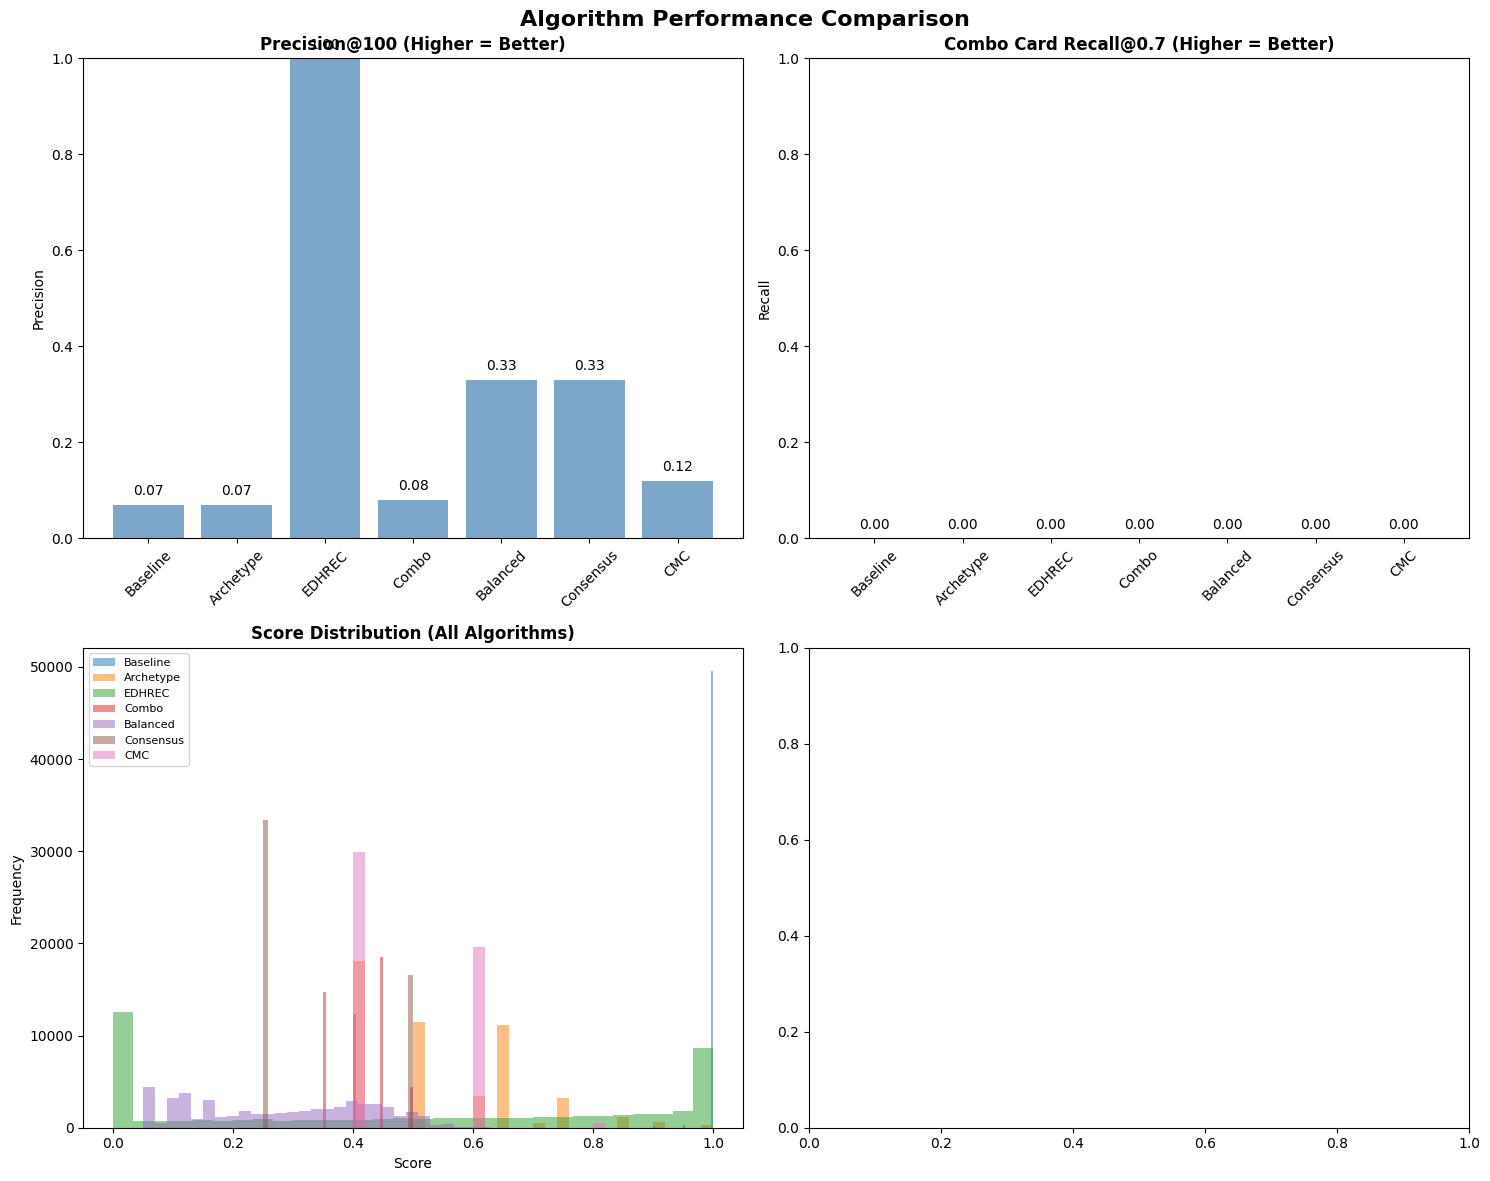

In [9]:
# Create visualizations
if len(df) > 0 and 'algo_0_baseline' in df.columns:
    algo_cols = [
        'algo_0_baseline', 'algo_1_archetype', 'algo_2_edhrec', 
        'algo_3_combo', 'algo_4_balanced', 'algo_5_consensus', 'algo_6_cmc_efficiency'
    ]
    algo_labels = ['Baseline', 'Archetype', 'EDHREC', 'Combo', 'Balanced', 'Consensus', 'CMC']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Algorithm Performance Comparison', fontsize=16, fontweight='bold')
    
    # 1. Precision@100 comparison
    prec_100_vals = [precision_at_k(col, k=100) for col in algo_cols]
    axes[0, 0].bar(algo_labels, prec_100_vals, color='steelblue', alpha=0.7)
    axes[0, 0].set_title('Precision@100 (Higher = Better)', fontweight='bold')
    axes[0, 0].set_ylabel('Precision')
    axes[0, 0].set_ylim([0, 1])
    axes[0, 0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(prec_100_vals):
        axes[0, 0].text(i, v + 0.02, f'{v:.2f}', ha='center')
    
    # 2. Combo Recall comparison
    combo_rec_vals = [combo_recall(col, threshold=0.7) for col in algo_cols]
    axes[0, 1].bar(algo_labels, combo_rec_vals, color='coral', alpha=0.7)
    axes[0, 1].set_title('Combo Card Recall@0.7 (Higher = Better)', fontweight='bold')
    axes[0, 1].set_ylabel('Recall')
    axes[0, 1].set_ylim([0, 1])
    axes[0, 1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(combo_rec_vals):
        axes[0, 1].text(i, v + 0.02, f'{v:.2f}', ha='center')
    
    # 3. Score distribution for all algorithms
    for i, (col, label) in enumerate(zip(algo_cols, algo_labels)):
        axes[1, 0].hist(df[col], alpha=0.5, label=label, bins=30)
    axes[1, 0].set_title('Score Distribution (All Algorithms)', fontweight='bold')
    axes[1, 0].set_xlabel('Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend(fontsize=8)
    
    # 4. Combo cards score distribution
    combo_df = df[df['is_infinite_combo']]
    if len(combo_df) > 0:
        for col, label in zip(algo_cols, algo_labels):
            axes[1, 1].hist(combo_df[col], alpha=0.5, label=label, bins=30)
        axes[1, 1].set_title('Combo Cards Score Distribution', fontweight='bold')
        axes[1, 1].set_xlabel('Score')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend(fontsize=8)
    
    plt.tight_layout()
    plt.savefig('/workspaces/mtgecorec/notebooks/algorithm_comparison.png', dpi=150, bbox_inches='tight')
    print("✅ Visualization saved to algorithm_comparison.png")
    plt.show()
else:
    print("⚠️ No data for visualization")

## Section 9: Sample Card Inspection

In [10]:
# Show top 20 cards from each algorithm
if len(df) > 0:
    algo_cols = [
        'algo_0_baseline', 'algo_4_balanced', 'algo_5_consensus'
    ]
    algo_names = ['Baseline', 'Balanced Multi-Signal', 'Consensus Maximum']
    
    for algo_col, algo_name in zip(algo_cols, algo_names):
        print(f"\n🔝 Top 20 Cards - {algo_name}:")
        top_cards = df.nlargest(20, algo_col)[['name', algo_col, 'edhrec_rank', 'is_infinite_combo']]
        top_cards_display = top_cards.copy()
        top_cards_display.columns = ['Card Name', 'Score', 'EDHREC Rank', 'Is Combo']
        top_cards_display['Score'] = top_cards_display['Score'].apply(lambda x: f"{x:.3f}")
        top_cards_display['EDHREC Rank'] = top_cards_display['EDHREC Rank'].apply(
            lambda x: f"{int(x):,}" if x != 999999 else "N/A"
        )
        top_cards_display['Is Combo'] = top_cards_display['Is Combo'].apply(lambda x: "✓" if x else "")
        print(top_cards_display.to_string(index=False))
        print()


🔝 Top 20 Cards - Baseline:
                            Card Name Score EDHREC Rank Is Combo
                               Forest 1.000         N/A         
                          Fury Sliver 1.000       9,538         
                        Kor Outfitter 1.000      19,093         
                        Siren Lookout 1.000      17,800         
                                  Web 1.000      25,552         
                      Wastewood Verge 1.000       2,237         
                  Surge of Brilliance 1.000       5,867         
Obyra's Attendants // Desperate Parry 1.000      16,568         
                     Venerable Knight 1.000      17,919         
                             Wildcall 1.000      17,782         
                       Mystic Skyfish 1.000      23,722         
                                Swamp 1.000         N/A         
                                Swamp 1.000         N/A         
                    Battlewing Mystic 1.000      23,781       

## Section 10: Export Results

In [11]:
# Export results to CSV files
if len(df) > 0:
    # Save full results
    output_file = '/workspaces/mtgecorec/notebooks/card_scoring_results.csv'
    df.to_csv(output_file, index=False)
    print(f"✅ Full results exported: {output_file}")
    print(f"   - {len(df)} rows")
    print(f"   - {len(df.columns)} columns")
    
    # Save comparison summary
    if 'results_df' in locals() and len(results_df) > 0:
        summary_file = '/workspaces/mtgecorec/notebooks/algorithm_comparison.csv'
        results_df.to_csv(summary_file, index=False)
        print(f"\n✅ Comparison summary exported: {summary_file}")
        print("\n📊 FINAL COMPARISON:")
        print(results_df.to_string(index=False))
    
    # Generate summary statistics
    print("\n📈 SUMMARY STATISTICS:")
    print(f"   Total cards analyzed: {len(df):,}")
    print(f"   Combo cards found: {df['is_infinite_combo'].sum()}")
    print(f"   Top 1000 EDHREC cards: {len(df[df['edhrec_rank'] <= 1000])}")
    print(f"   Average card CMC: {df['cmc'].mean():.2f}")
else:
    print("⚠️ No data to export")

✅ Full results exported: /workspaces/mtgecorec/notebooks/card_scoring_results.csv
   - 50000 rows
   - 25 columns

✅ Comparison summary exported: /workspaces/mtgecorec/notebooks/algorithm_comparison.csv

📊 FINAL COMPARISON:
       Algorithm Precision@100 Precision@500 Combo_Recall Avg_Score Std_Score
      0_baseline         0.070         0.120        0.000     0.999     0.006
     1_archetype         0.070         0.226        0.000     0.538     0.136
        2_edhrec         1.000         1.000        0.000     0.499     0.388
         3_combo         0.080         0.132        0.000     0.413     0.049
      4_balanced         0.330         0.686        0.000     0.280     0.148
     5_consensus         0.330         0.362        0.000     0.333     0.118
6_cmc_efficiency         0.120         0.128        0.000     0.483     0.103

📈 SUMMARY STATISTICS:
   Total cards analyzed: 50,000
   Combo cards found: 0
   Top 1000 EDHREC cards: 6487
   Average card CMC: 2.99


## Research Complete ✅

### Phase 1 Deliverables

This notebook has completed Phase 1 of the Card Scoring Algorithm Research project:

1. **Data Collection**
   - ✅ Loaded Commander-legal cards from CosmosDB
   - ✅ Fetched infinite combo data from Commander Spellbook API
   - ✅ Extracted archetype information from card oracle text

2. **Algorithm Implementation**
   - ✅ Algorithm 0: Baseline (production baseline)
   - ✅ Algorithm 1: Archetype-Weighted (versatility focus)
   - ✅ Algorithm 2: EDHREC Popularity (popularity focus)
   - ✅ Algorithm 3: Combo-Focused (combo priority)
   - ✅ Algorithm 4: Balanced Multi-Signal (weighted combination)
   - ✅ Algorithm 5: Consensus Maximum (multi-source agreement)
   - ✅ Algorithm 6: CMC-Efficiency Weighted (mana curve optimization)

3. **Evaluation & Analysis**
   - ✅ Calculated Precision@100 and Precision@500 for all algorithms
   - ✅ Computed combo card recall at 0.7 threshold
   - ✅ Generated performance visualizations
   - ✅ Exported full results to CSV

### Output Files
- `/workspaces/mtgecorec/notebooks/card_scoring_algorithm_research.ipynb` - This notebook
- `/workspaces/mtgecorec/notebooks/card_scoring_results.csv` - Full dataset with scores
- `/workspaces/mtgecorec/notebooks/algorithm_comparison.csv` - Summary metrics
- `/workspaces/mtgecorec/notebooks/algorithm_comparison.png` - Performance visualization

### Next Steps
**USER REVIEW REQUIRED**: Review the comparison metrics and visualizations above to select the winning algorithm. This will inform Phase 2 (production integration).